In [1]:
'''
Load packages for data manipulation
'''
import numpy as np
import pandas as pd

'''
Load Packages for data visualization
'''
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
from plotly.offline import plot, iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
import plotly.tools as tls
init_notebook_mode(connected=True)

'''
Load packages for model building
'''
from sklearn.model_selection import train_test_split
import scipy.spatial.distance as metric
from math import sqrt, floor
import sklearn.preprocessing

'''
Load some used packages, will be used for data sorting and math opeartions 
'''
import operator
import math

'''
Suppress warnings
'''
import warnings
warnings.filterwarnings("ignore")

# Data 

Please, download the data to your working folder.On the webpage you can find its description. 

https://archive.ics.uci.edu/ml/datasets/Iris


In [2]:
'''
Load data from disk
'''
iris = pd.read_csv('iris.data',header=None, names=['sl', 'sw', 'pl', 'pw', 'target'])

## Explore the data

### You are free to use all descriptive and visualization methods we have discussed so far. Dig deeper and see what you can find :)

In [3]:
'''
At first let's see the dimension of our dataset
'''
iris.shape

(150, 5)

In [4]:
'''
Check if there is any missing values.
'''
print(iris.info())
print('\n')
print(iris.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sl        150 non-null float64
sw        150 non-null float64
pl        150 non-null float64
pw        150 non-null float64
target    150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB
None


sl        0
sw        0
pl        0
pw        0
target    0
dtype: int64


In [5]:
'''
Show statistical measures, such as count mean median and others
'''
iris.describe()

,sl,sw,pl,pw
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


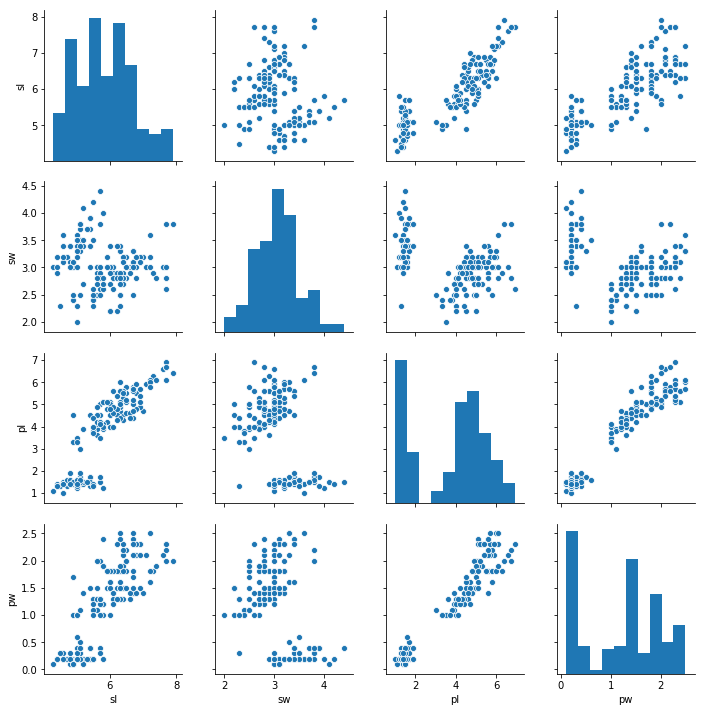

In [6]:
'''
scatter plot between features
'''
sns.pairplot(iris);

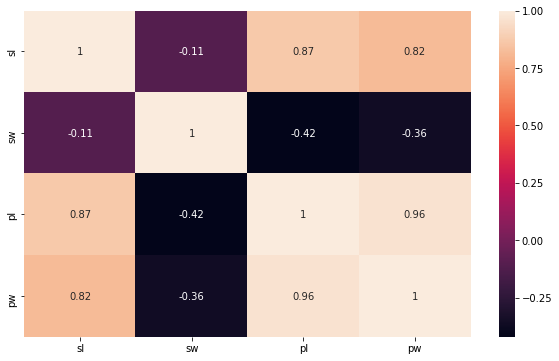

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(iris.corr(),annot=True)
plt.show()


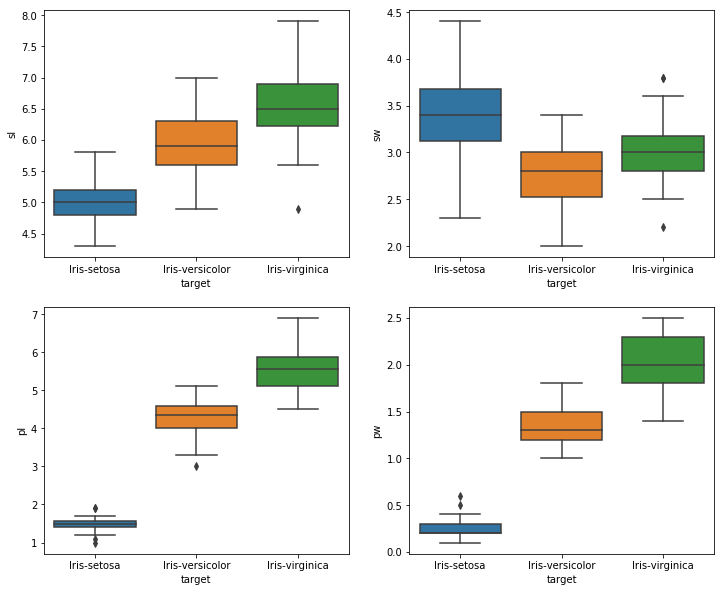

In [8]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.boxplot(x='target',y='sl',data=iris)
plt.subplot(2,2,2)
sns.boxplot(x='target',y='sw',data=iris)
plt.subplot(2,2,3)
sns.boxplot(x='target',y='pl',data=iris)
plt.subplot(2,2,4)
sns.boxplot(x='target',y='pw',data=iris)

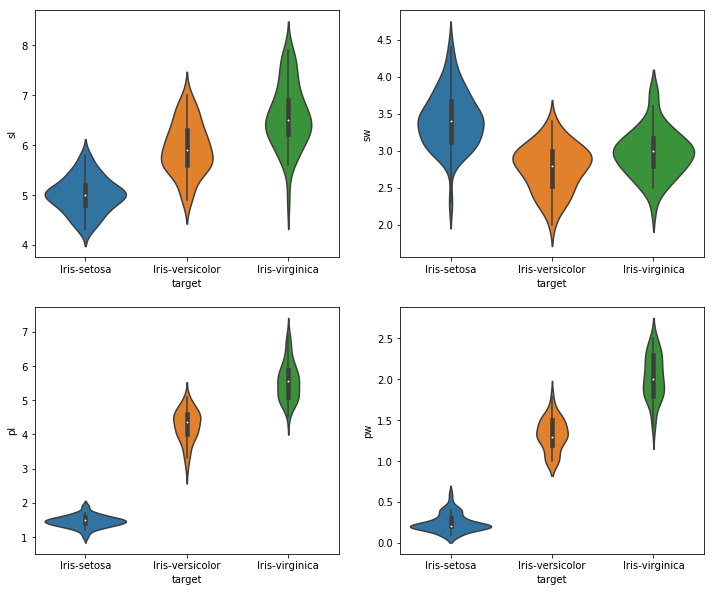

In [9]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.violinplot(x='target',y='sl',data=iris)
plt.subplot(2,2,2)
sns.violinplot(x='target',y='sw',data=iris)
plt.subplot(2,2,3)
sns.violinplot(x='target',y='pl',data=iris)
plt.subplot(2,2,4)
sns.violinplot(x='target',y='pw',data=iris);

In [10]:
'''
Show the relationship between <sepal length , sepal width and petal length>
'''

data = []
for i in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    trace = go.Scatter3d(x = iris[iris["target"] == i].iloc[:, 0],
                         y = iris[iris["target"] == i].iloc[:, 1],
                         z = iris[iris["target"] == i].iloc[:, 2],
                         mode = 'markers',
                         name = "class_{}".format(i),
                         marker = dict(size = 3))
    data.append(trace)
    layout=dict(
        title='Scatter plot between sepal length, sepal width and petal length'
    )
figure = dict(data=data, layout = layout)
iplot(figure)

In [11]:
data = []
for i in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    trace = go.Scatter3d(x = iris[iris["target"] == i].iloc[:, 0],
                         y = iris[iris["target"] == i].iloc[:, 2],
                         z = iris[iris["target"] == i].iloc[:, 3],
                         mode = 'markers',
                         name = "class_{}".format(i),
                         marker = dict(size = 3))
    data.append(trace)
    layout=dict(
        title='Scatter plot between sepal length, petal length and petal width'
    )
figure = dict(data=data, layout = layout)
iplot(figure)

In [12]:
data = []
for i in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    trace = go.Scatter3d(x = iris[iris["target"] == i].iloc[:, 0],
                         y = iris[iris["target"] == i].iloc[:, 1],
                         z = iris[iris["target"] == i].iloc[:, 3],
                         mode = 'markers',
                         name = "class_{}".format(i),
                         marker = dict(size = 3))
    data.append(trace)
    layout=dict(
        title='Scatter plot between sepal length, sepal width and petal width'
    )
figure = dict(data=data, layout = layout)
iplot(figure)

In [13]:
data = []
for i in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    trace = go.Scatter3d(x = iris[iris["target"] == i].iloc[:, 1],
                         y = iris[iris["target"] == i].iloc[:, 2],
                         z = iris[iris["target"] == i].iloc[:, 3],
                         mode = 'markers',
                         name = "class_{}".format(i),
                         marker = dict(size = 3))
    data.append(trace)
    layout=dict(
        title='Scatter plot between sepal width, petal length and petal width'
    )
figure = dict(data=data, layout = layout)
iplot(figure)

## Clustering

### Implement the K-means algorithm

In [14]:
def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.
    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

In [15]:
def initialize(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.

    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

# def initialize2(ds, k):

#     '''
#     Create random cluster centroids

#     Parameters:
#     -----------
#     ds: ndarray
#         Dataset to cluster instances from
#     k: int
#         The number of clusters

#     Returns:
#     --------
#     ndarray
#         k centroids as numpy ndarray
#     '''

#     # Number of attributes in dataset
#     n = np.shape(ds)[1]

#     # The centroids
#     centroids = np.mat(np.zeros((k,n)))

#     # Create random centroids (get min, max attribute values, randomize in that range)
#     for j in range(n):
#         min_j = min(ds[:,j])
#         range_j = float(max(ds[:,j]) - min_j)
#         centroids[:,j] = min_j + range_j * np.random.rand(k, 1)

#     # Return centroids as numpy array
#     return centroids

def euclidean_dist(A, B):

    '''
    Calculate Euclidean distance between 2 n-dimension points

    Parameters:
    -----------
    A: ndarray
        vector of point coordinates to compare
    B: ndarray
        vector of point coordinates to compare
    Returns:
    --------
    float
        calculated Euclidean distance of the 2 vectors
    '''
    
    return metric.euclidean(A, B)


In [16]:
def cluster(ds, k):

    '''
    The k-means clustering algorithm
    
    Parameters:
    -----------
    ds: ndarray
        Dataset to cluster instances from
    k: int
        The number of clusters
    Returns:
    --------
    ndarray
        Resulting centroids after clustering
    ndarray
        Cluster assignments after clustering
    int
        Number of iterations required by clustering algorithm
    ndarray
        Original centroids
    '''

    # Number of rows in dataset
    m = np.shape(ds)[0]
    n = np.shape(ds)[1]

    # Hold the instance cluster assignments
    cluster_assignments = np.mat(np.zeros((m, 2)))

    # Initialize centroids
    cents = initialize(ds, k)
    
    # Preserve original centroids
    cents_orig = cents.copy()
    
    changed = True
    num_iter = 0

    # Loop until no changes to cluster assignments
    while changed:

        changed = False

        # For every instance (row in dataset)
        for i in range(m):

            # Track minimum distance, and vector index of associated cluster
            min_dist = np.inf
            min_index = -1

            # Calculate distances
            for j in range(k):

                dist_ji = euclidean_dist(cents[j,:], ds[i,:])
                if dist_ji < min_dist:
                    min_dist = dist_ji
                    min_index = j

            # Check if cluster assignment of instance has changed
            if cluster_assignments[i, 0] != min_index: 
                changed = True

            # Assign instance to appropriate cluster
            cluster_assignments[i, :] = min_index, min_dist**2

            
        points_matrix = np.mat(np.zeros((k, n)))
        # Update centroid location
        for cent in range(k):
            points = ds[np.nonzero(cluster_assignments[:,0].A == cent)[0]]
            points_matrix[cent,:] = np.mean(points, axis=0)
        for cent in range(k):
            if ~np.isnan(points_matrix[cent, :].A).any():
                cents[cent,:] = points_matrix[cent, :].A

        # Count iterations
        num_iter += 1

    # Return important stuff when done
    return cents, cluster_assignments, num_iter, cents_orig

### Choose the best-K, using the elbow method 

In [17]:
iris_ds = iris.iloc[:, 0:4].values
minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
iris_ds = minmax_scaler.fit_transform(iris_ds)

# K = 1 to 18,for every k value we calculate distortion,then we plot the line graph between K and Distortion
distortions = []
K = list(range(1,18))

for k in K:
    centroids, cluster_assignments, iters, orig_centroids = cluster(iris_ds, k)
    distortions.append(np.sum(cluster_assignments[:, 1]))
    
# plt.plot(K,distortions,'bx-');
trace = go.Scatter(x = K,y = distortions, mode = 'lines',
                   marker = dict(size = 10,color="rgba(152,0,0,0.5)")
                  )

data = [trace]
layout=dict(
        title='The changing of distortion depending on K',
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text='K',
                font=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text='distortion',
                font=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        )
    )
figure = dict(data=data, layout=layout)
iplot(figure)

### See whether the clustering algorithm really captures the underlying data distribution by assigning labels to each cluster and comparing with ground truth

In [18]:
centroids, cluster_assignments, iters, orig_centroids = cluster(iris_ds, 3)
iris['cluster'] = cluster_assignments[:,0]
iris['target'] = pd.factorize(iris.target)[0]
iris.cluster = iris.cluster.astype(int)

In [19]:
np.sum(iris.target == iris.cluster)

133